In [1]:
import tensorflow as tf
from dataset_tf import VoxDataset, DataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
# from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from weighted_mse import WeightedLoss
# from weighted_chamfer_loss import WeightedChamferLoss
import matplotlib.pyplot as plt
import keras
import pickle
import os

In [2]:
tf.__version__

'2.15.0'

In [3]:
dataset = VoxDataset(gender="f")

In [4]:
ids = dataset.get_ids()
len(ids)

43200


2160

In [5]:
len(ids)

2160

In [6]:
len(dataset)

43200

In [7]:
def get_split():
    DATASET_SIZE = len(dataset.get_ids())

    train_size = int(0.6 * DATASET_SIZE)
    val_size = int(0.2 * DATASET_SIZE)
    test_size = DATASET_SIZE - train_size - val_size

    np.random.seed(42)
    np.random.shuffle(ids)

    # Split the indices into training, validation, and test sets
    train_indices = ids[:train_size]
    val_indices = ids[train_size:train_size + val_size]
    test_indices = ids[train_size + val_size:DATASET_SIZE]

    train = VoxDataset(ids=train_indices)
    # test = VoxDataset(ids=test_indices)
    val = VoxDataset(ids=val_indices)

    return train, 0, val

In [8]:
train, _, val = get_split()

43200


In [9]:
train_ids = train.get_ids()
# test_ids = test.get_ids()
val_ids = val.get_ids()

25920
8640


In [10]:
val.annotations.shape

(8640, 8)

In [11]:
# df = test.get_df_()
# df.shape

In [12]:
# df.head(50)

In [13]:
# df['id'].value_counts()

In [14]:
# sorted(test_ids)

In [15]:
print(len(train))
# print(len(test))
print(len(val))

25920
8640


In [16]:
import tensorflow as tf

def AutoEncoder():
    # Define input layer
    input_layer = tf.keras.layers.Input(shape=(384,))
    
    # Encoder layers
    encoder = tf.keras.layers.Dense(384, activation='tanh')(input_layer)

    # encoder = input_layer

    # attention = tf.keras.layers.Attention()([encoder, encoder])
    # weighted_bottleneck = tf.keras.layers.multiply([attention, encoder])

    # attention = tf.keras.layers.Attention()([weighted_bottleneck, weighted_bottleneck])
    # weighted_bottleneck = tf.keras.layers.multiply([attention, weighted_bottleneck])
    
    # attention = tf.keras.layers.Attention()([weighted_bottleneck, weighted_bottleneck])
    # weighted_bottleneck = tf.keras.layers.multiply([attention, weighted_bottleneck])

    # attention = tf.keras.layers.Attention()([weighted_bottleneck, weighted_bottleneck])
    # weighted_bottleneck = tf.keras.layers.multiply([attention, weighted_bottleneck])

    # Bottleneck Decoders 
    decoder = tf.keras.layers.Dense(384, activation='tanh')(encoder)
    decoder = tf.keras.layers.Dense(500, activation='tanh')(decoder)
    decoder = tf.keras.layers.Dense(768, activation='tanh')(decoder)
    decoder = tf.keras.layers.Dense(1000, activation='tanh')(decoder)
    decoder = tf.keras.layers.Dense(1536, activation='tanh')(decoder)
    decoder = tf.keras.layers.Dense(2000, activation='tanh')(decoder)
    # decoder = tf.keras.layers.Dense(3072, activation='tanh')(decoder)
    # decoder = tf.keras.layers.Dense(4000, activation='tanh')(decoder)
    # decoder = tf.keras.layers.Dense(5000, activation='tanh')(decoder) # change from last
    # decoder = tf.keras.layers.Dense(12288, activation='tanh')(decoder) # change from last
    # decoder = tf.keras.layers.Dense(15000, activation='tanh')(decoder) # layer to comment when training female
    # decoder = tf.keras.layers.Dense(15069, activation='tanh')(decoder)

    decoder_output = tf.keras.layers.Dense(15069, activation='tanh')(decoder)
    
    # Define the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=decoder_output)
    
    return model

In [17]:
num_epochs = 100
batch = 32
loss_weight = 1
model_name = "e1_w_ones_w_weightedMSE_w_customL2_10l_lr00001_female_directed_hausdorff"
# model_name = "test"

In [18]:
try:
  os.mkdir(f"./models/{model_name}")
except FileExistsError:
  pass

In [19]:
train = DataGenerator(train, batch_size=batch)
val = DataGenerator(val, batch_size=batch)
# test = DataGenerator(test, batch_size=batch)

In [20]:
model = AutoEncoder()


2024-05-05 00:42:15.315649: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-05 00:42:15.315673: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-05 00:42:15.315677: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-05 00:42:15.315727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-05 00:42:15.315904: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
# print(len(test[len(test)-1][1]))

In [22]:
attention_ids = np.load("./weight_indices.npy")

In [23]:
len(attention_ids)

3540

In [24]:
with open('custom_loss_dict.pkl', 'rb') as file:
    custom_metric = pickle.load(file)

In [25]:
base_loss = tf.keras.losses.MeanSquaredError()

weighted_loss = WeightedLoss(base_loss=base_loss, attention_ids=attention_ids,custom_metric_dict=custom_metric, weight=loss_weight, batch_size=batch)
# weighted_chamfer_loss = WeightedChamferLoss(attention_ids=attention_ids, weight=loss_weight, batch_size=batch)

In [26]:
# for i in tqdm(weights):
#     print(i, end='\r')

In [27]:
# Define the learning rate decay schedule
# learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.001,
#     decay_steps=num_epochs * 3,
#     decay_rate=0.1,
#     staircase=True
# )

# Create the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)

# Compile the model with the optimizer
model.compile(optimizer=optimizer, loss=weighted_loss)

early_stopping_val_loss = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
early_stopping_train_loss = EarlyStopping(monitor='loss', patience=7, verbose=1)

# Train the model using model.fit
history = model.fit(train, epochs=num_epochs, batch_size=batch, validation_data=val, 
          callbacks=[early_stopping_train_loss, early_stopping_val_loss]
          )

Epoch 1/100


2024-05-05 00:42:16.475058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


810/810 [==============================] - 92s 111ms/step - loss: 335.8179 - val_loss: 55.6563
Epoch 2/100
810/810 [==============================] - 84s 104ms/step - loss: 50.4947 - val_loss: 43.4710
Epoch 3/100
810/810 [==============================] - 82s 101ms/step - loss: 43.2777 - val_loss: 44.7648
Epoch 4/100
810/810 [==============================] - 79s 98ms/step - loss: 40.7728 - val_loss: 36.8464
Epoch 5/100
810/810 [==============================] - 89s 110ms/step - loss: 37.6728 - val_loss: 32.9463
Epoch 6/100
810/810 [==============================] - 83s 102ms/step - loss: 35.7268 - val_loss: 36.1631
Epoch 7/100
810/810 [==============================] - 78s 96ms/step - loss: 33.7443 - val_loss: 33.5107
Epoch 8/100
810/810 [==============================] - 78s 96ms/step - loss: 32.8982 - val_loss: 34.4183
Epoch 9/100
810/810 [==============================] - 78s 96ms/step - loss: 31.6097 - val_loss: 31.2543
Epoch 10/100
810/810 [==============================] - 78s 9

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384)]             0         
                                                                 
 dense (Dense)               (None, 384)               147840    
                                                                 
 dense_1 (Dense)             (None, 384)               147840    
                                                                 
 dense_2 (Dense)             (None, 500)               192500    
                                                                 
 dense_3 (Dense)             (None, 768)               384768    
                                                                 
 dense_4 (Dense)             (None, 1000)              769000    
                                                                 
 dense_5 (Dense)             (None, 1536)              153753

In [29]:
import pickle

with open(f'./models/{model_name}/loss_config.pkl', 'wb') as file:
    pickle.dump(weighted_loss.get_config(), file)

# loss = model.evaluate(test)
# acc = 0

In [30]:
# print(f"Accuracy: {acc*100:.4f}%\nLoss: {loss:.4f}")

In [31]:
model.save(f'./models/{model_name}/model.h5')

/Users/naweenk/miniforge3/envs/demo/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
weighted_loss = WeightedLoss(base_loss=base_loss, attention_ids=attention_ids,custom_metric_dict=custom_metric, weight=loss_weight, batch_size=1)

In [33]:
weighted_loss.get_config()

{'base_loss': <keras.src.losses.MeanSquaredError at 0x320d79c00>,
 'attention_ids': array([   0,    1,    2, ..., 5020, 5021, 5022]),
 'weight': 1,
 'batch_size': 1,
 'custom_metric_dict': {'nose_bridge': [3516, 3526],
  'r_eye_lid': [3690, 2265],
  'l_eye_lid': [3856, 809],
  'lip': [3543, 3503],
  'r_lip_bend': [2850, 3798],
  'l_lip_bend': [1735, 3021],
  'r_lip_jaw': [3798, 3406],
  'l_lip_jaw': [3021, 3614],
  'lip_chin': [3503, 3487],
  'orbital_lower': [3710, 3866],
  'oribtal_upper': [3154, 2135],
  'puffer': [3436, 3667],
  'mouth_corner': [2827, 1710],
  'jaw_end': [3406, 3614],
  'ear_end': [856, 288]}}

In [34]:
model = tf.keras.models.load_model(f"./models/{model_name}/model.h5", 
    custom_objects={"WeightedLoss" : weighted_loss})


In [35]:
loss = model.evaluate(train)
acc = 0

810/810 [==============================] - 61s 75ms/step - loss: 19.1239


In [36]:
y_pred = []

In [37]:
# test[419][0].shape

In [38]:
# model.predict(test[0][0]).shape

In [39]:
for i in tqdm(train):
    pred = (model.predict(i[0], verbose=0)
              *201.41335
            )
    for j in range(len(pred)):
        y_pred.append([i[1][j], VoxDataset.to_mesh_points(pred[j])])



100%|██████████| 810/810 [01:20<00:00, 10.06it/s]


In [40]:
len(y_pred)

25920

In [41]:
import open3d as o3d
import numpy as np

for index, i in enumerate(tqdm(y_pred)):
    vertices = o3d.utility.Vector3dVector(i[1])
    triangles = o3d.utility.Vector3iVector(dataset.get_faces())
    mesh = o3d.geometry.TriangleMesh(vertices, triangles)
    o3d.io.write_triangle_mesh(f"./Test/data_{index}.obj", mesh, 
                            #    write_ascii=False
                               )

100%|██████████| 25920/25920 [13:55<00:00, 31.02it/s]


In [42]:
# test_ids

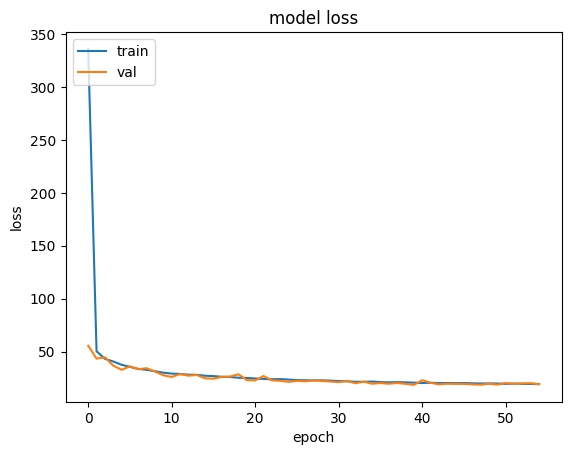

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.ylim(0, 20)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f"./models/{model_name}/loss.png")
plt.show()

In [44]:
# import numpy as np
# from scipy.spatial import Delaunay
# import trimesh

# points = y_pred[0]

# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points)

# # Estimate normals for the point cloud
# pcd.estimate_normals()

# # Create a surface mesh from the point cloud using Poisson reconstruction
# mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# # Visualize the mesh (optional)
# o3d.visualization.draw_geometries([mesh])

In [45]:
# point_cloud = o3d.geometry.PointCloud()
# triangle_mesh = o3d.geometry.TriangleMesh()

# # Define the point cloud data (replace with your actual data)

# point_cloud.points = o3d.utility.Vector3dVector(i)

# # Define the triangle data (replace with your actual data)
# triangles = dataset.get_faces()  # Example triangle indices
# triangle_mesh.triangles = triangles

# # Combine the point cloud and triangle mesh into a single geometry (optional)
# combined_geometry = point_cloud + triangle_mesh  # Combine point cloud and mesh

# # Write the geometry to a PLY file
# o3d.io.write_point_cloud("point_cloud_and_mesh.ply", combined_geometry)

In [46]:
# test[0][0].shape